# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/Fall 2022/CS 445/Project 2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [ ]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [ ]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """

    output = np.zeros((out_size, out_size, 3))
    # print(output.shape)
    nPat = int(out_size / patch_size)
    for i in range(nPat): 
      for j in range(nPat):
        rx = int(random.random() * (sample.shape[0] - patch_size))
        ry = int(random.random() * (sample.shape[1] - patch_size))
        tile = sample[rx:rx+patch_size,ry:ry+patch_size]
        output[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = tile
    return output/255

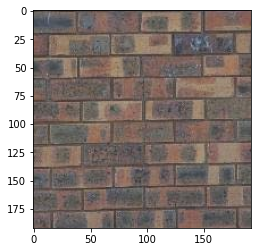

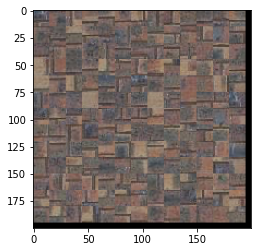

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
from numpy.ma.core import choose
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    # Moves through output in increments of (patch_size - overlap), looks for the best
    # match from all patch options and populates template area with this patch
    sample.astype(np.float64)
    output = np.zeros((out_size, out_size, 3), np.float64) # Make output np array equal to desired size
    inc = patch_size - overlap # Increment size is based off distance where patches do not overlap with the next one

    # Choose random patch to start
    rx = int(random.random() * (sample.shape[0] - patch_size)) 
    ry = int(random.random() * (sample.shape[1] - patch_size))
    output[:patch_size,:patch_size] = sample[rx:rx+patch_size,ry:ry+patch_size]

    # Cycle through all potential patch locations 
    for i in range(0, out_size - patch_size, inc): 
      for j in range(0, out_size - patch_size, inc):
        mask = np.zeros((patch_size, patch_size), np.uint8)
        # Mask only applies in one direction for first row and column
        if (i == 0 and j == 0): # first patch is already determined before entering loop
          continue
        if (j >= inc): 
          mask[:,:overlap] = 1.0 # Set all values in vertical overlapped section to 1
        if (i >= inc):
          mask[:overlap,:] = 1.0 # Set all values in horizontal overlapped section to 1
        template = output[i:i + patch_size,j:j + patch_size]
        ssd = ssd_patch(template/2, mask, sample/2)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2] # Exclude border images from consideration
        r,c = choose_sample(ssd, tol)

        # Save patch at chosen location to output array
        output[i:i + patch_size,j:j+patch_size] = \
        sample[r:r+patch_size, c:c+patch_size].copy()

    return output/255


In [ ]:
# Computes cost of sampling each past into the current region, aka the template
# Returns the costs of selecting the patch centered at that pixel for entire image
def ssd_patch(T, M, I):
  T1, T2, T3 = cv2.split(T) # Split T and I into channels. M is only one channel (1s or 0s)
  I1, I2, I3 = cv2.split(I)

  # Calculated SSD separately for all 3 channels
  ssd_cost_1 = ((M*T1)**2).sum() - 2 * cv2.filter2D(I1, ddepth=-1, kernel = M*T1) + \
  cv2.filter2D(I1 ** 2, ddepth=-1, kernel=M)
  ssd_cost_2 = ((M*T2)**2).sum() - 2 * cv2.filter2D(I2, ddepth=-1, kernel = M*T2) + \
  cv2.filter2D(I2 ** 2, ddepth=-1, kernel=M)
  ssd_cost_3 = ((M*T3)**2).sum() - 2 * cv2.filter2D(I3, ddepth=-1, kernel = M*T3) + \
  cv2.filter2D(I3 ** 2, ddepth=-1, kernel=M)

  ssd = np.zeros((I.shape[0],I.shape[1]))
  ssd = ssd_cost_1 + ssd_cost_2 + ssd_cost_3 # Generate single SSD based off channel SSD's
  return np.absolute(ssd) # Make sure all values are positive 

In [ ]:
# Takes cost array and tolerance threshold, returns
# the row and column of the #tol lowest costs
def choose_sample(cost, tol):
  costInd = np.argsort(cost.flatten()) # Cost is flattened automatically
  # need to look at cost[costInd] values and choose lowest #tol values
  rand = (int)(random.random()*tol) # random number between 0 and tol
  index = np.unravel_index(costInd[rand], cost.shape) # chooses an index to return from list of lowest cost indices 
  return index

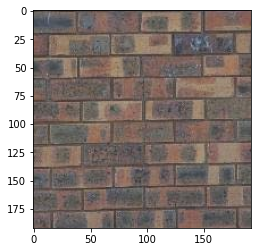

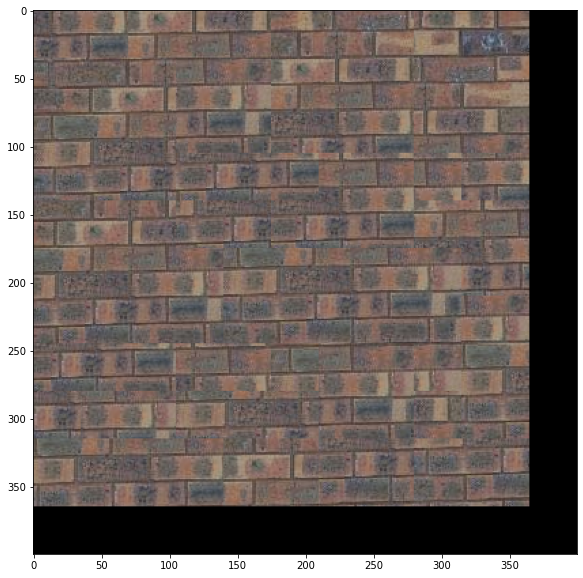

In [ ]:
sample_img_fn = 'samples/bricks_small.jpg' 
im_file = datadir + sample_img_fn
sample_img = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 50
overlap = 15
tol = 1
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) # feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    sample.astype(np.float64)
    output = np.zeros((out_size, out_size, 3), np.float64)
    
    inc = patch_size - overlap
    numPatch = (out_size-overlap) // (patch_size-overlap)

    # Choose random patch to start
    rx = int(random.random() * (sample.shape[0] - patch_size)) 
    ry = int(random.random() * (sample.shape[1] - patch_size))
    output[:patch_size,:patch_size] = sample[rx:rx+patch_size,ry:ry+patch_size]

    for i in range(0, out_size - patch_size, inc):
      for j in range(0, out_size - patch_size, inc):
        mask = np.zeros((patch_size, patch_size), np.uint8)
        if (i == 0 and j == 0):
          continue
        top_overlap, left_overlap = False, False
        if (j >= inc):
          mask[:,:overlap] = 1.0 
          left_overlap = True
        if (i >= inc):
          mask[:overlap,:] = 1.0
          top_overlap = True
        template = output[i:i + patch_size,j:j + patch_size]
        ssd = ssd_patch(template/2, mask, sample/2)
        ssd = ssd[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        r,c = choose_sample(ssd, tol)
        new_patch = sample[r:r+patch_size, c:c+patch_size].copy()

        # Calculate the cost by finding bndcost (sum of squared differences between
        # channels of newly sample patch and template)
        # apply cut to transposed patch using bndcost

        t1, t2, t3 = cv2.split(template)
        p1, p2, p3 = cv2.split(new_patch)
        bndcost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2 # Calculate pixel-wise sum of squared differences between template and chosen patch
        path_mask = np.zeros((patch_size,patch_size),np.uint8)
        mask1 = np.zeros((patch_size,patch_size),np.uint8)
        mask2 = np.zeros((patch_size,patch_size),np.uint8)

        # Choose appropriate mask to dictate which pixels come from which patch
        if left_overlap and top_overlap:
          mask1 = cut(bndcost.T).T
          mask2 = cut(bndcost)
          path_mask = np.logical_and(mask1,mask2).astype(np.uint8) # Finds intersection of masks for each seam 
        elif left_overlap:
          path_mask = cut(bndcost.T).T
        elif top_overlap:
          path_mask = cut(bndcost)
        
        mask = np.zeros((patch_size,patch_size,3), np.uint8)
        mask[:,:,0] = path_mask # Convert mask into three channels so it can be applied to patch
        mask[:,:,1] = path_mask
        mask[:,:,2] = path_mask
        inv_mask = np.ones(mask.shape) - mask
        output[i:i + patch_size,j:j+patch_size] = mask*new_patch + template*inv_mask

    return output/255

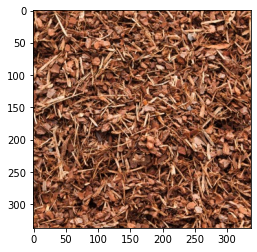

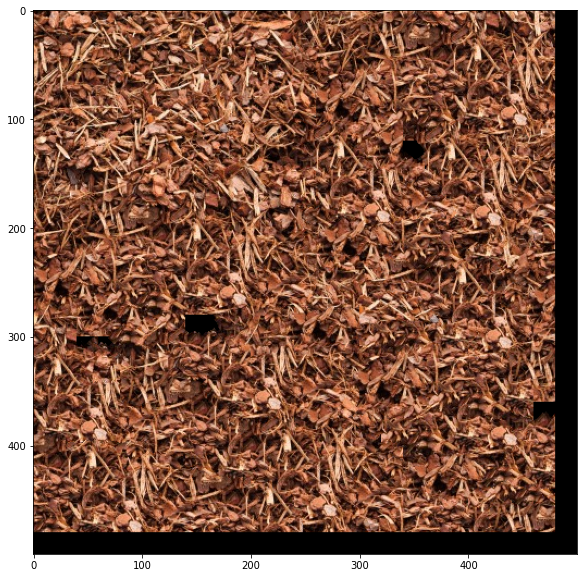

In [ ]:
sample_img_fn = 'samples/bark.jpg' 
im_file = datadir + sample_img_fn
sample_img = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 40
overlap = 20
tol = 1
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # Similar to quilt_cut but uses an additional cost term based on the difference between the sampled
    # source patch and the target patch
    # Uses a weighted sum, alpha times block overlap error plus (1-alpha) times squared error 
    # between correspondence map pixels within the source texture block and template

    sample.astype(np.float64)
    guidance_im.astype(np.float64)
    output = np.zeros((guidance_im.shape[0], guidance_im.shape[1], 3), np.float64) # output needs to be same size as guiding image
    inc = patch_size - overlap

    rx = int(random.random() * (sample.shape[0] - patch_size)) # Choose random patch to start
    ry = int(random.random() * (sample.shape[1] - patch_size))
    output[:patch_size,:patch_size] = sample[rx:rx+patch_size,ry:ry+patch_size]

    # Cylce through all possible patch destinations in output, which equals the size of guidance_im
    for i in range(0, guidance_im.shape[0] - patch_size, inc): 
      for j in range(0, guidance_im.shape[1] - patch_size, inc):
        mask = np.zeros((patch_size, patch_size), np.uint8)
        if (i == 0 and j == 0):
          continue
        top_overlap, left_overlap = False, False
        if (j >= inc):
          mask[:,:overlap] = 1.0 
          left_overlap = True
        if (i >= inc):
          mask[:overlap,:] = 1.0
          top_overlap = True
        template = output[i:i + patch_size,j:j + patch_size]
        guide = guidance_im[i:i + patch_size,j:j + patch_size]
        ssd1 = ssd_patch(template/2, mask, sample/2) # First SSD for template vs texture img
        ssd1 = ssd1[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        ssd2 = ssd_patch(guide/2, mask, sample/2) # Second SSD for guide vs texture img
        ssd2 = ssd2[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        # print(np.average(ssd1))
        # print(np.average(ssd2))
        # ssd1 = normalize(ssd1)
        # ssd2 = normalize(ssd2)
        ssd = alpha*ssd1 + (1-alpha)*ssd2 # Weighted SSD based off alpha parameter
        r,c = choose_sample(ssd, tol)
        new_patch = sample[r:r+patch_size, c:c+patch_size].copy()

        t1, t2, t3 = cv2.split(template)
        p1, p2, p3 = cv2.split(new_patch)
        bndcost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2
        
        path_mask = np.zeros((patch_size,patch_size),np.uint8)
        mask1 = np.zeros((patch_size,patch_size),np.uint8)
        mask2 = np.zeros((patch_size,patch_size),np.uint8)

        if left_overlap and top_overlap:
          mask1 = cut(bndcost.T).T
          mask2 = cut(bndcost)
          path_mask = np.logical_and(mask1,mask2).astype(np.uint8)
        elif left_overlap:
          path_mask = cut(bndcost.T).T
        elif top_overlap:
          path_mask = cut(bndcost)
        
        mask = np.zeros((patch_size,patch_size,3), np.uint8)
        mask[:,:,0] = path_mask
        mask[:,:,1] = path_mask
        mask[:,:,2] = path_mask
        inv_mask = np.ones(mask.shape) - mask
        output[i:i + patch_size,j:j+patch_size] = mask*new_patch + template*inv_mask
    
    return output/255

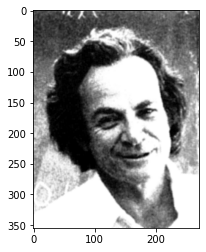

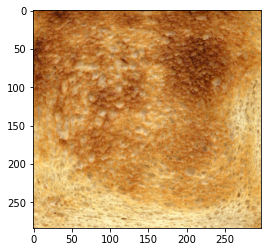

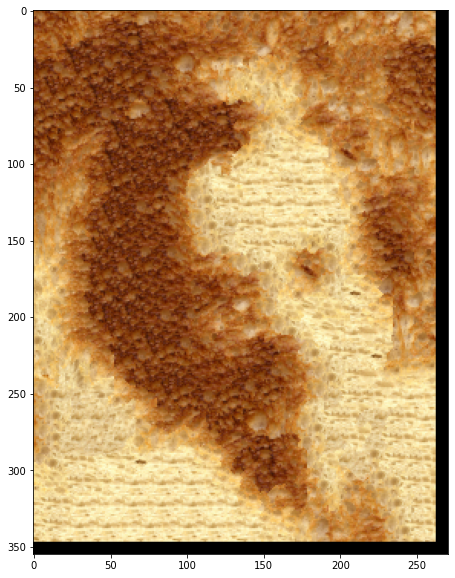

In [ ]:
# load/process appropriate input texture and guidance images
sample_img_fn = 'samples/feynman.tiff' 
im_file = datadir + sample_img_fn
guidance_img = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

texture_img_fn = 'samples/toast.png' 
texture_file = datadir + texture_img_fn
texture_img = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()

patch_size = 25
overlap = 11
tol = 3
alpha = 0.65
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [ ]:
def iterative_texture_transfer(sample, patch_size, overlap, tol, guidance_im, N):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # Similar to quilt_cut but uses an additional cost term based on the difference between the sampled
    # source patch and the target patch
    # Uses a weighted sum, alpha times block overlap error plus (1-alpha) times squared error 
    # between correspondence map pixels within the source texture block and template

    sample.astype(np.float64)
    guidance_im.astype(np.float64)
    output = np.zeros((guidance_im.shape[0], guidance_im.shape[1], 3), np.float64) # output needs to be same size as guiding image
    prev = np.zeros(output.shape, np.float64)


    # Same as texture transfer but with multiple iterations, changing alpha, 
    # reducing block size, and matching blocks to previous iterations
    for count in range (0,N):
      alpha = 0.8 * ((count)/(N-1)) + 0.1
      inc = patch_size - overlap
      rx = int(random.random() * (sample.shape[0] - patch_size)) # Choose random patch to start
      ry = int(random.random() * (sample.shape[1] - patch_size))
      output[:patch_size,:patch_size] = sample[rx:rx+patch_size,ry:ry+patch_size]
      print("alpha: ", alpha)
      print("patch size: ", patch_size)
      for i in range(0, guidance_im.shape[0] - patch_size, inc): 
        for j in range(0, guidance_im.shape[1] - patch_size, inc):
          mask = np.zeros((patch_size, patch_size), np.uint8)
          if (i == 0 and j == 0 and count == 0):
            continue
          top_overlap, left_overlap = False, False
          if (j >= inc):
            mask[:,:overlap] = 1.0 
            left_overlap = True
          if (i >= inc):
            mask[:overlap,:] = 1.0
            top_overlap = True
          template = output[i:i + patch_size,j:j + patch_size].copy()
          guide = guidance_im[i:i + patch_size,j:j + patch_size].copy()
          # ssd1 now needs to incorporate matching with synthesis at previous iteration
          if count > 0:
            prev_temp = prev[i:i + patch_size,j:j + patch_size].copy()
            # print(template - prev_temp)
            # plt.figure(figsize=(5,5))
            # plt.imshow(template/255)
            # plt.show()
            # plt.figure(figsize=(5,5))
            # plt.imshow(prev_temp/255)
            # plt.show()
            ssd1 = ssd_patch(template/2, mask, sample/2)
            ssd2 = ssd_patch(prev_temp/2, np.ones(mask.shape), sample/2)
            # print("count", count)
            # print("ssd1: ",np.average(ssd1))
            # print("ssd2: ",np.average(ssd2))
            # ssd1 = normalize(ssd1)
            # ssd2 = normalize(ssd2)
            # print(ssd1 - ssd2)
            # print(ssd2)
            ssd_t = ssd1+ssd2
          else:
            ssd_t = ssd_patch(template/2, mask, sample/2) # First SSD for template vs texture img
          ssd_t = ssd_t[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].copy()
          # print("ssd_t: ",np.average(ssd_t))
          ssd_g = ssd_patch(guide/2, mask, sample/2) # Second SSD for guide vs texture img
          ssd_g = ssd_g[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2].copy()
          # print("ssd_g: ",np.average(ssd_g))
          # ssd_g = normalize(ssd_g)
          ssd = alpha*ssd_t + (1-alpha)*ssd_g # Weighted SSD based off alpha parameter
          r,c = choose_sample(ssd, tol)
          new_patch = sample[r:r+patch_size, c:c+patch_size].copy()

          t1, t2, t3 = cv2.split(template)
          p1, p2, p3 = cv2.split(new_patch)
          bndcost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2
          # print(bndcost)
          
          path_mask = np.zeros((patch_size,patch_size),np.uint8)
          mask1 = np.zeros((patch_size,patch_size),np.uint8)
          mask2 = np.zeros((patch_size,patch_size),np.uint8)

          if left_overlap and top_overlap:
            mask1 = cut(bndcost.T).T
            mask2 = cut(bndcost)
            path_mask = np.logical_and(mask1,mask2).astype(np.uint8)
          elif left_overlap:
            path_mask = cut(bndcost.T).T
          elif top_overlap:
            path_mask = cut(bndcost)
          
          pmask = np.zeros((patch_size,patch_size,3), np.uint8)

          # if i == 2*inc:
          #   plt.figure(figsize=(5,5))
          #   plt.imshow(path_mask)
          #   plt.show()

          pmask[:,:,0] = path_mask
          pmask[:,:,1] = path_mask
          pmask[:,:,2] = path_mask
          inv_mask = np.ones(pmask.shape) - pmask
          output[i:i + patch_size,j:j+patch_size] = pmask*new_patch + template*inv_mask
          
          # if count > 0:
          #   plt.figure(figsize=(5,5))
          #   plt.imshow(prev/255)
          #   # plt.figure(figsize=(5,5))
          #   # plt.imshow(output/255)
          #   plt.show()
          
      prev = output.copy()
      plt.figure(figsize=(10,10))
      plt.imshow(prev/255)
      patch_size = (int)(patch_size * 2 / 3)
      overlap = (int)(overlap * 2 / 3)

      # Print img after each cycle
      plt.figure(figsize=(10,10))
      # plt.imshow(output/255)
      plt.show()

    return output/255

In [ ]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

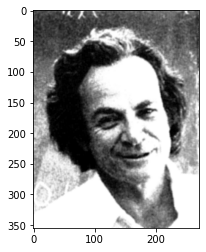

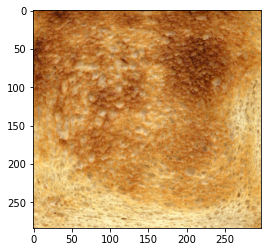

alpha:  0.1
patch size:  40


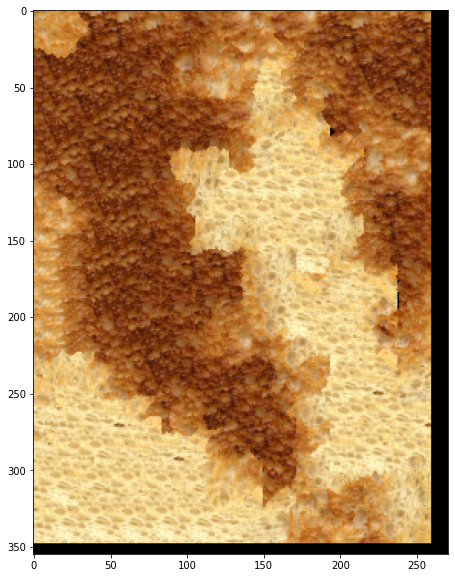

<Figure size 720x720 with 0 Axes>

alpha:  0.5
patch size:  26


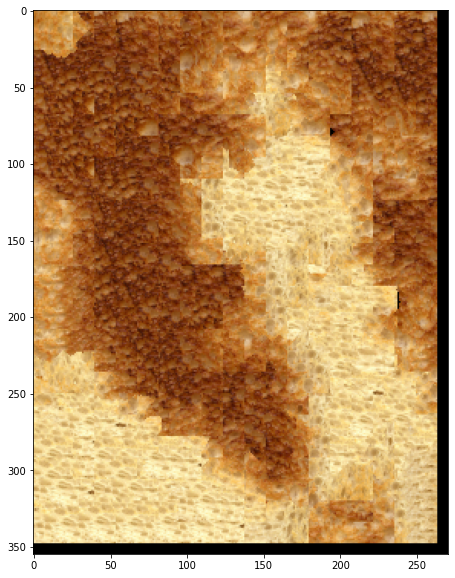

<Figure size 720x720 with 0 Axes>

alpha:  0.9
patch size:  17


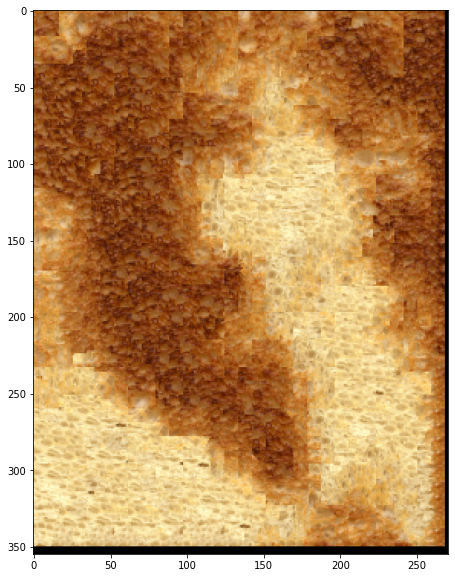

<Figure size 720x720 with 0 Axes>

In [ ]:
# load/process appropriate input texture and guidance images
sample_img_fn = 'samples/feynman.tiff' 
im_file = datadir + sample_img_fn
guidance_img = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

texture_img_fn = 'samples/toast.png' 
texture_file = datadir + texture_img_fn
texture_img = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()

patch_size = 40
overlap = 18
tol = 2
cycles = 3
res = iterative_texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, cycles)

# plt.figure(figsize=(10,10))
# plt.imshow(res)
# plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [ ]:
def toast_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    
    # Similar to quilt_cut but uses an additional cost term based on the difference between the sampled
    # source patch and the target patch
    # Uses a weighted sum, alpha times block overlap error plus (1-alpha) times squared error 
    # between correspondence map pixels within the source texture block and template

    sample.astype(np.float64)
    guidance_im.astype(np.float64)
    output = np.zeros((guidance_im.shape[0], guidance_im.shape[1], 3), np.float64) # output needs to be same size as guiding image
    inc = patch_size - overlap

    rx = int(random.random() * (sample.shape[0] - patch_size)) # Choose random patch to start
    ry = int(random.random() * (sample.shape[1] - patch_size))
    output[:patch_size,:patch_size] = sample[rx:rx+patch_size,ry:ry+patch_size]

    # Cylce through all possible patch destinations in output, which equals the size of guidance_im
    for i in range(0, guidance_im.shape[0] - patch_size, inc): 
      for j in range(0, guidance_im.shape[1] - patch_size, inc):
        mask = np.zeros((patch_size, patch_size), np.uint8)
        if (i == 0 and j == 0):
          continue
        top_overlap, left_overlap = False, False
        if (j >= inc):
          mask[:,:overlap] = 1.0 
          left_overlap = True
        if (i >= inc):
          mask[:overlap,:] = 1.0
          top_overlap = True
        template = output[i:i + patch_size,j:j + patch_size]
        guide = guidance_im[i:i + patch_size,j:j + patch_size]
        ssd1 = ssd_patch(template/2, mask, sample/2) # First SSD for template vs texture img
        ssd1 = ssd1[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        ssd2 = ssd_patch(guide/2, mask, sample/2) # Second SSD for guide vs texture img
        ssd2 = ssd2[patch_size//2:-patch_size//2, patch_size//2:-patch_size//2]
        # print(np.average(ssd1))
        # print(np.average(ssd2))
        # ssd1 = normalize(ssd1)
        # ssd2 = normalize(ssd2)
        ssd = alpha*ssd1 + (1-alpha)*ssd2 # Weighted SSD based off alpha parameter
        r,c = choose_sample(ssd, tol)
        new_patch = sample[r:r+patch_size, c:c+patch_size].copy()

        t1, t2, t3 = cv2.split(template)
        p1, p2, p3 = cv2.split(new_patch)
        bndcost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2
        
        path_mask = np.zeros((patch_size,patch_size),np.uint8)
        mask1 = np.zeros((patch_size,patch_size),np.uint8)
        mask2 = np.zeros((patch_size,patch_size),np.uint8)

        if left_overlap and top_overlap:
          mask1 = cut(bndcost.T).T
          mask2 = cut(bndcost)
          path_mask = np.logical_and(mask1,mask2).astype(np.uint8)
        elif left_overlap:
          path_mask = cut(bndcost.T).T
        elif top_overlap:
          path_mask = cut(bndcost)
        
        mask = np.zeros((patch_size,patch_size,3), np.uint8)
        mask[:,:,0] = path_mask
        mask[:,:,1] = path_mask
        mask[:,:,2] = path_mask
        inv_mask = np.ones(mask.shape) - mask
        output[i:i + patch_size,j:j+patch_size] = mask*new_patch + template*inv_mask
    
    return output/255

(270, 270, 3)


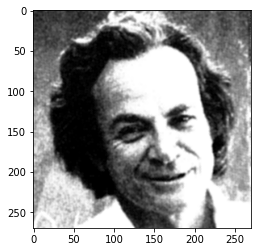

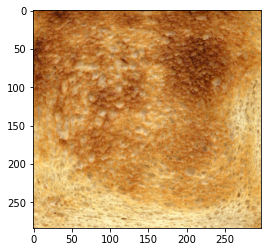

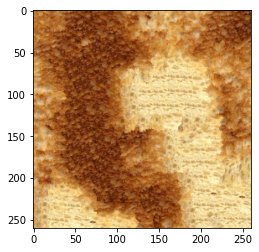

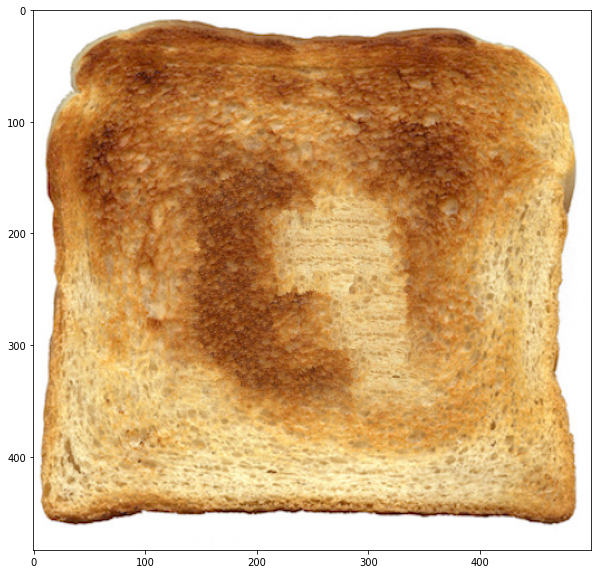

In [ ]:
# load/process appropriate input texture and guidance images
sample_img_fn = 'samples/feynman.tiff' 
im_file = datadir + sample_img_fn
guidance_img = cv2.cvtColor(cv2.imread(im_file), cv2.COLOR_BGR2RGB)
guidance_img = guidance_img[30:300,1:]
print(guidance_img.shape)
plt.imshow(guidance_img)
plt.show()

texture_img_fn = 'samples/toast.png' 
texture_file = datadir + texture_img_fn
texture_img = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()

toast_img_fn = 'samples/toast.jpg' 
toast_file = datadir + toast_img_fn
toast_img = cv2.cvtColor(cv2.imread(toast_file), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 8
tol = 1
alpha = 0.65
face = toast_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
face = face[:-10,:-10]
plt.imshow(face)
plt.show()

inPoint = np.array([110,110]) # Where face should go in toast
area = 40 # Layers to iterate over
res = blend(toast_img,face*255,inPoint,area)

plt.figure(figsize=(10,10))
plt.imshow(res)
# plt.figure(figsize=(10,10))
# plt.imshow(new_res)
plt.show()

In [ ]:
def blend(toast, tface, inPt, N):
  res = toast.copy()
  back = toast[inPt[0]:inPt[0]+tface.shape[0],inPt[1]:inPt[1]+tface.shape[1]] # toast in face area
  
  # range = np.array([[inPt[0]-N, inPt[0]+N+tface.shape[0]], [inPt[1]-N, inPt[1]+N+tface.shape[1]]])
  
  # Loop through face textured image, moving inwards
  # Blend face and background toast while increasing alpha
  for i in range(0, N):
    alpha =  (0.7 * ((i)/(N-1)) + 0.05)
    currFace = tface[i:tface.shape[0]-i,i:tface.shape[1]-i]
    currToast = toast[inPt[0]+i:inPt[0]+tface.shape[0]-i,inPt[1]+i:inPt[1]+tface.shape[1]-i]
    res[inPt[0]+i:inPt[0]+tface.shape[0]-i,inPt[1]+i:inPt[1]+tface.shape[1]-i] = \
    (currFace*alpha + currToast*(1-alpha))
  
  return res

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).